Saving googledata.zip to googledata (2).zip
  symbol                       date   close    high       low    open  \
0   GOOG  2016-06-14 00:00:00+00:00  718.27  722.47  713.1200  716.48   
1   GOOG  2016-06-15 00:00:00+00:00  718.92  722.98  717.3100  719.00   
2   GOOG  2016-06-16 00:00:00+00:00  710.36  716.65  703.2600  714.91   
3   GOOG  2016-06-17 00:00:00+00:00  691.72  708.82  688.4515  708.65   
4   GOOG  2016-06-20 00:00:00+00:00  693.71  702.48  693.4100  698.77   

    volume  adjClose  adjHigh    adjLow  adjOpen  adjVolume  divCash  \
0  1306065    718.27   722.47  713.1200   716.48    1306065      0.0   
1  1214517    718.92   722.98  717.3100   719.00    1214517      0.0   
2  1982471    710.36   716.65  703.2600   714.91    1982471      0.0   
3  3402357    691.72   708.82  688.4515   708.65    3402357      0.0   
4  2082538    693.71   702.48  693.4100   698.77    2082538      0.0   

   splitFactor  
0          1.0  
1          1.0  
2          1.0  
3          1.0  

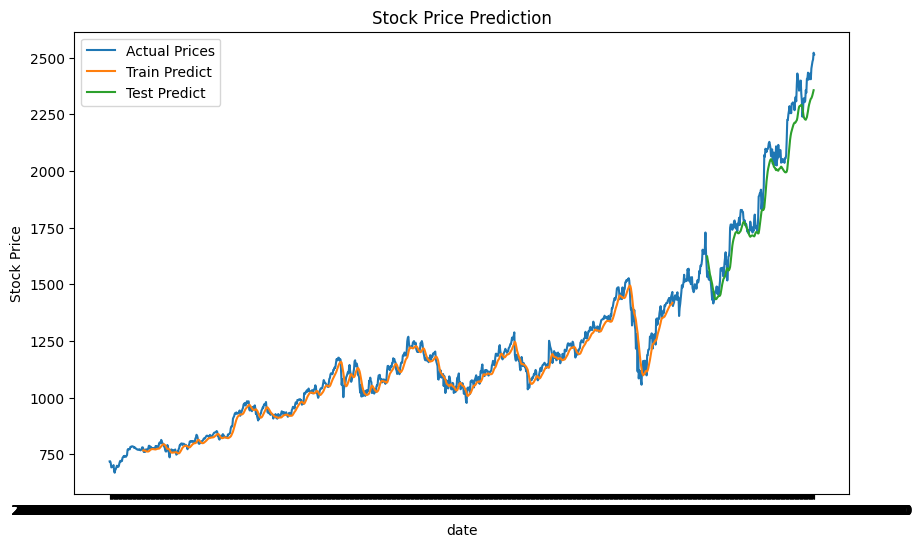

In [3]:
# Setup Environment
!pip install numpy pandas scikit-learn tensorflow matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset from Kaggle
from google.colab import files
uploaded = files.upload()

# Load the CSV file
df = pd.read_csv(list(uploaded.keys())[0])

# Display the first few rows of the dataset
print(df.head())

# Preprocess data
# Assuming 'Close' is the target variable
data = df['close'].values
data = data.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets for LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'], label='Actual Prices')
plt.plot(df['date'][time_step:len(train_predict) + time_step], train_predict, label='Train Predict')
plt.plot(df['date'][len(train_predict) + (time_step * 2) + 1:len(df) - 1], test_predict, label='Test Predict')
plt.xlabel('date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()
